This notebook optimizes the threshold for the BDT based on the figure of merit of signal significance

\begin{equation}
\frac{s_i}{\sqrt{s_i+b_i}}
\end{equation}

To avoid biasing ourselves towards data fluctuation, we extract $s_0$ and $b_0$ from a fit for data passing a certain threshold, then use BDT efficiencies extracted from application to test data to evaluate

\begin{equation}
s_i=\frac{s_0 \varepsilon_i^s}{\varepsilon_0^s} \\
b_i=\frac{b_0 \varepsilon_i^b}{\varepsilon_0^b}
\end{equation}

In [53]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib
import joblib
import time

In [90]:
## Threshold for preliminary fit for optimization
## Choose one that isn't that high, but shows the signal peak
threshold = 0.9

In [18]:
## Self explanatory
save_plots = False
## Toggle plot titles (off for thesis and papers, generally speaking)
show_titles = True
## Toggle plot grid
show_grid = False
## Black and white?
black_and_white = True
## If true, require DTF with double m.c. to be successful
dtf_success = False

In [3]:
training_params = {
    'learning_rate' : 0.005623,
    'max_leaf_nodes' : 200,
    'max_iter' : 2500
}

In [4]:
## Proton and pion momenta
## 'VF': use VF momenta
## 'DTF': use DTF momenta w/ JPsi m.c.
## 'DTFL': use DTF momenta w/ JPsi and Lambda m.c.
## 'NO': don't use any momenta for Lambda daughter particles
daughter_momenta = 'DTF'

In [5]:
classifier_dump_filename = (
    'HBDT_'
    + daughter_momenta
    + '_' + str(training_params['learning_rate'])
    + '_' + str(training_params['max_leaf_nodes'])
    + '_' + str(training_params['max_iter'])
)

classifier_dump_filename

'HBDT_DTF_0.005623_200_2500'

In [26]:
## Create plots directory, if missing
repo_dir = str(pathlib.Path.home()) + '/classifier-studies/'

plot_directory = (
    repo_dir + 'plots/'
    + 'threshold_optimization/'
)

state_directory = repo_dir + '20_HBDT/' + 'saved_states/'

In [10]:
path_to_hd5_files = str(pathlib.Path.home()) + '/data/'
input_mc = path_to_hd5_files + 'LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'
input_data = path_to_hd5_files + 'LHCbData_2016-2017-2018_MagUpDown_Dimuon_Ttracks_v2.h5'

# Monte Carlo data

In [11]:
df_reco = pd.read_hdf(input_mc, key='LHCbMC_Lb')
df_truth = pd.read_hdf(input_mc, key='LHCbMCTruth_Lb')
df_mc = pd.merge(df_truth.loc[df_truth['Rec_key'] >= 0], df_reco, left_index=True, right_on='MC_key')
df_mc = df_mc.loc[(df_mc['MC_key'] >= 0) & (df_mc['Rec_key'] >= 0)]

del(df_reco, df_truth)

## Pre-selection cuts

In [14]:
def p_modulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

def transverse_p_modulus(px, py):
    return np.sqrt(px**2 + py**2)

In [12]:
jpsi_pdg_mass = 3096.900

In [17]:
## Missing "combined" invariant masses (for Lambda->p pim and Lambdab->JPsi Lambda)
## These are the AM in the DaVinci config file. Did Salvatore implement them somewhere?

pion_p_cuts = (
    (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) > 2000)
    & (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) < 5e5)
)

proton_p_cuts = (
    (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) > 10000)
    & (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) < 5e5)
)

proton_pt_cuts = transverse_p_modulus(df_mc['p_PX'], df_mc['p_PY']) > 400

lambda_m_cuts = (df_mc['L_M'] > 600) & (df_mc['L_M'] < 1500)
lambda_mm_cuts = df_mc['L_MM'] < 1500
lambda_z_cuts = (df_mc['L_ENDVERTEX_Z'] > 5500) & (df_mc['L_ENDVERTEX_Z'] < 8500)
lambda_dira_cuts = df_mc['L_BPVDIRA'] > 0.9999
lambda_ipchi2_cuts = df_mc['L_BPVIPCHI2'] < 200
lambda_vdchi2_cuts = df_mc['L_BPVVDCHI2'] < 2e7
lambda_chi2_cuts = df_mc['L_VFASPF_CHI2_VDOF'] < 750
lambda_pt_cuts = transverse_p_modulus(df_mc['L_PX'], df_mc['L_PY']) > 450

jpsi_m_cuts = abs(df_mc['Jpsi_M'] - jpsi_pdg_mass) < 90

lambdab_m_cuts = df_mc['Lb_M'] < 8500
lambdab_dira_cuts = abs(df_mc['Lb_BPVDIRA']) > 0.99
lambdab_ipchi2_cuts = df_mc['Lb_BPVIPCHI2'] < 1750
lambdab_chi2_cuts = df_mc['Lb_VFASPF_CHI2_VDOF'] < 150

dtf_success_cuts = df_mc['DTF_FixJPsiLambda_status'] == 'Success'

In [19]:
pre_selection_cuts = (
    pion_p_cuts &
    proton_p_cuts &
    proton_pt_cuts &
    lambda_m_cuts &
    lambda_mm_cuts &
    lambda_z_cuts &
    lambda_dira_cuts &
    lambda_ipchi2_cuts &
    lambda_vdchi2_cuts &
    lambda_chi2_cuts &
    lambda_pt_cuts &
    jpsi_m_cuts &
    lambdab_m_cuts &
    lambdab_dira_cuts &
    lambdab_ipchi2_cuts &
    lambdab_chi2_cuts
)

if dtf_success:
    pre_selection_cuts = pre_selection_cuts & dtf_success_cuts

df_mc[pre_selection_cuts]

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType_y,MC_key
Rec_key,,,,,,,,,,,,,,,,,,,,,
0,0.9512,-0.1669,26.401600,343.742889,-192.429398,4751.548828,2031.640015,-1218.119995,29336.890625,445.510010,...,-186.566345,5411.963379,-804.469727,-535.944397,22858.960938,1438.071777,1619.347290,23634.302734,T,0
1,0.8237,-0.2123,3.514200,140.238602,325.837311,7463.102539,367.250000,1035.959961,24602.169922,174.279999,...,222.666214,4137.976074,-605.608093,594.454895,11170.495117,71.893692,-2873.631348,73489.484375,T,29
8,0.5442,-0.4049,-30.064199,-237.463104,-161.438004,5029.397461,-1999.180054,-1447.800049,43812.398438,-599.280029,...,-151.918823,7139.517578,100.262436,999.515259,50033.699219,-120.737198,-995.344788,6822.337402,T,277
14,0.9904,-0.2075,-9.769600,224.561996,56.081600,5921.048828,2894.560059,699.140015,74302.851562,293.929993,...,104.645416,10220.954102,-884.967468,195.843964,34903.839844,1645.699585,-1113.117432,24484.212891,T,367
17,0.8236,-0.2738,28.986401,-296.374695,-100.123802,5963.561523,-1268.760010,-522.340027,25478.310547,-184.460007,...,20.153040,3543.737305,-829.315674,-926.117676,37815.328125,2614.833252,-1553.520630,63936.839844,T,493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366374,1.9930,-0.9682,33.883499,454.162109,-444.944794,6047.499512,7053.950195,-6800.229980,92633.132812,949.369995,...,-1059.302368,13806.107422,2310.392578,-2437.838867,42988.765625,2057.492432,-877.707703,10357.686523,T,8921400
366378,1.2187,-0.0757,-10.080700,120.471603,-69.038300,7221.361328,1256.689941,-628.059998,71476.546875,189.229996,...,-259.237457,19192.976562,1663.037476,477.534760,14450.500000,-812.013245,-604.744568,27734.162109,T,8921503
366382,1.1575,-0.3940,43.910599,4.075100,-146.877396,7409.937500,133.949997,-2934.969971,147684.812500,-69.339996,...,-295.752747,15403.834961,196.509079,-679.625732,6668.261719,3547.472900,-3286.872803,190998.375000,T,8921603


# Real data

In [20]:
df_data = pd.read_hdf(input_data, key='LHCbData')

In [22]:
if dtf_success:
    data_cuts = df_data['DTF_FixJPsiLambda_status'] == 'Success'
else:
    data_cuts = pd.Series(True, index=df_data.index)

df_data[data_cuts]

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_p_PX,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType
0,0.632911,0.178342,5.049691,-255.844345,-56.212456,5932.708984,0.6329,0.1792,5.047500,-2260.323975,...,-388.787109,-100.817314,6799.227051,-793.328735,54.095398,4428.873047,552.359741,-1187.884155,58499.570312,T
1,0.819310,-0.207494,-12.258046,-82.289032,-16.596403,6057.988770,0.8168,-0.2077,-12.286400,-1174.547974,...,1581.436157,529.397705,-47227.988281,-676.136108,-172.411438,10995.480469,3460.861572,-314.394806,44735.148438,T
2,0.839784,-0.138968,5.569199,110.246147,-332.334747,7637.261719,0.8398,-0.1389,5.569000,238.606934,...,-29.898186,-330.129730,4088.551514,-335.475464,856.159424,4723.041016,-2293.340088,-2661.276123,15929.165039,T
3,0.974854,-0.085595,20.542496,-32.013988,97.482521,6381.826660,0.9740,-0.0862,20.537600,-520.050232,...,106.603920,171.913254,6129.576660,1989.267334,506.550293,31564.787109,3074.307373,855.257324,15494.530273,T
4,0.915558,-0.309900,-33.831448,-129.211182,-8.126650,7658.323242,0.9167,-0.3099,-33.824600,-1304.095825,...,-239.040604,-38.133430,10148.586914,-1010.378479,-945.691162,13932.727539,2256.578613,-1760.062866,39286.671875,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43650399,0.920726,0.124357,-35.697220,-25.280413,-83.092720,5795.710449,0.9197,0.1259,-35.683701,-119.704796,...,-250.229828,-360.737305,20884.945312,-584.001160,-807.857605,37060.625000,-1443.146240,1148.041992,13961.532227,T
43650400,-0.093952,0.845374,1.271360,-122.958611,-51.635925,8243.633789,-0.0940,0.8450,1.268400,-1565.407349,...,-255.560867,14.982138,13138.872070,854.051758,-604.327454,23594.082031,-1561.843384,1333.551880,23915.330078,T
43650401,0.025143,-0.081066,45.549873,-122.141373,83.132690,6721.934082,0.0270,-0.0805,45.506199,-3068.416748,...,-827.581482,812.201172,46583.406250,-6609.394043,-2259.331543,151869.171875,-4153.620117,195.239365,139170.406250,T
43650402,0.813911,0.249597,10.735976,103.988853,219.124115,6743.214355,0.8164,0.2494,10.746000,527.023315,...,1347.746216,2635.279785,78033.671875,388.208771,1950.822021,106508.710938,564.650146,-777.457642,15552.646484,T


# Add derived variables

In [23]:
def add_derived_variables(
    df: pd.DataFrame
) -> None:
    df['p_PT'] = transverse_p_modulus(df['p_PX'], df['p_PY'])
    df['DTF_FixJPsi_p_PT'] = transverse_p_modulus(df['DTF_FixJPsi_p_PX'], df['DTF_FixJPsi_p_PY'])
    df['DTF_FixJPsiLambda_p_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_p_PX'], df['DTF_FixJPsiLambda_p_PY'])
    df['pim_PT'] = transverse_p_modulus(df['pim_PX'], df['pim_PY'])
    df['DTF_FixJPsi_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsi_pim_PX'], df['DTF_FixJPsi_pim_PY'])
    df['DTF_FixJPsiLambda_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_pim_PX'], df['DTF_FixJPsiLambda_pim_PY'])
    df['Jpsi_PT'] = transverse_p_modulus(df['Jpsi_PX'], df['Jpsi_PY'])
    
    dtf_success_mapper = {
        'Success': 0.0,
        'Failed': 1.0,
        'NonConverged': 3.0
    }

    df.replace({'DTF_FixJPsi_status': dtf_success_mapper}, inplace=True)
    df.replace({'DTF_FixJPsiLambda_status': dtf_success_mapper}, inplace=True)

In [24]:
add_derived_variables(df_mc)
add_derived_variables(df_data)

# Drop based on pre-selection

In [51]:
df_mc.drop(df_mc[~pre_selection_cuts].index, inplace=True)
df_data.drop(df_data[~data_cuts].index, inplace=True)

# Import HBDT

In [27]:
saved_state_file = state_directory + '/' + classifier_dump_filename + '.joblib'
HBDT = joblib.load(saved_state_file)

In [29]:
if daughter_momenta == 'VF':
    p_momenta = ['p_PT', 'p_PZ']
    pim_momenta = ['pim_PT', 'pim_PZ']
elif daughter_momenta == 'DTF':
    p_momenta = ['DTF_FixJPsi_p_PT', 'DTF_FixJPsi_p_PZ']
    pim_momenta = ['DTF_FixJPsi_pim_PT', 'DTF_FixJPsi_pim_PZ']
elif daughter_momenta == 'DTFL':
    p_momenta = ['DTF_FixJPsiLambda_p_PT', 'DTF_FixJPsiLambda_p_PZ']
    pim_momenta = ['DTF_FixJPsiLambda_pim_PT', 'DTF_FixJPsiLambda_pim_PZ']
elif daughter_momenta == 'NO':
    p_momenta = []
    pim_momenta = []
else:
    raise ValueError(daughter_momenta + " is not a valid option for momenta usage.")

In [30]:
fixed_features = [
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status'
]

features = p_momenta + pim_momenta + fixed_features

## Predict MC

In [55]:
tick = time.perf_counter()
mc_predicted = HBDT.predict_proba(df_mc.loc[:, features].to_numpy())[:,1]
tock = time.perf_counter()
print(f"MC events predicted in {(tock - tick):0.4f} seconds.")

MC events predicted in 4.5267 seconds.


In [57]:
df_mc['HBDT'] = mc_predicted
df_mc

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,TrackType_y,MC_key,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
Rec_key,,,,,,,,,,,,,,,,,,,,,
0,0.9512,-0.1669,26.401600,343.742889,-192.429398,4751.548828,2031.640015,-1218.119995,29336.890625,445.510010,...,T,0,3670.964844,2624.076172,2733.329834,311.089020,260.727386,334.741455,1259.644897,0.812270
1,0.8237,-0.2123,3.514200,140.238602,325.837311,7463.102539,367.250000,1035.959961,24602.169922,174.279999,...,T,29,962.454834,1039.160889,1095.172607,292.199097,262.192261,278.820038,2350.277832,0.848499
8,0.5442,-0.4049,-30.064199,-237.463104,-161.438004,5029.397461,-1999.180054,-1447.800049,43812.398438,-599.280029,...,T,277,6069.714355,2933.882812,354.068542,313.657623,496.833252,456.626129,16.075375,0.923516
14,0.9904,-0.2075,-9.769600,224.561996,56.081600,5921.048828,2894.560059,699.140015,74302.851562,293.929993,...,T,367,3138.222168,2606.361572,2835.955811,563.971436,397.024719,499.553711,1183.876953,0.960159
17,0.8236,-0.2738,28.986401,-296.374695,-100.123802,5963.561523,-1268.760010,-522.340027,25478.310547,-184.460007,...,T,493,1088.444824,1386.584595,1326.820923,503.365540,128.678238,192.515366,3060.318604,0.620781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366374,1.9930,-0.9682,33.883499,454.162109,-444.944794,6047.499512,7053.950195,-6800.229980,92633.132812,949.369995,...,T,8921400,9575.651367,11972.828125,9594.823242,1461.105103,1673.396362,1428.191162,5488.212402,0.975524
366378,1.2187,-0.0757,-10.080700,120.471603,-69.038300,7221.361328,1256.689941,-628.059998,71476.546875,189.229996,...,T,8921503,1055.863892,1285.636230,1963.163696,429.001678,345.132141,352.585876,855.027405,0.284203
366382,1.1575,-0.3940,43.910599,4.075100,-146.877396,7409.937500,133.949997,-2934.969971,147684.812500,-69.339996,...,T,8921603,4872.735840,3059.736816,1022.928284,265.291748,270.466003,294.877197,5446.465820,0.861701


## Predict Run 2

In [58]:
tick = time.perf_counter()
data_predicted = HBDT.predict_proba(df_data.loc[:, features].to_numpy())[:,1]
tock = time.perf_counter()
print(f"Data events predicted in {(tock - tick):0.4f} seconds.")

Data events predicted in 667.5044 seconds.


In [59]:
df_data['HBDT'] = data_predicted
df_data

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
0,0.632911,0.178342,5.049691,-255.844345,-56.212456,5932.708984,0.6329,0.1792,5.047500,-2260.323975,...,58499.570312,T,1525.044067,1.749454e+03,1781.845947,782.852173,321.232666,404.077881,1184.637451,0.000261
1,0.819310,-0.207494,-12.258046,-82.289032,-16.596403,6057.988770,0.8168,-0.2077,-12.286400,-1174.547974,...,44735.148438,T,521.194397,1.472479e+03,17636.072266,350.746094,2199.127930,7932.257812,2890.091064,0.000021
2,0.839784,-0.138968,5.569199,110.246147,-332.334747,7637.261719,0.8398,-0.1389,5.569000,238.606934,...,15929.165039,T,562.488403,3.194031e+02,667.377747,243.758881,295.576294,217.761917,3125.168213,0.000169
3,0.974854,-0.085595,20.542496,-32.013988,97.482521,6381.826660,0.9740,-0.0862,20.537600,-520.050232,...,15494.530273,T,1069.337402,3.339173e+02,110.629982,489.308746,321.725708,177.255829,5212.728516,0.000006
4,0.915558,-0.309900,-33.831448,-129.211182,-8.126650,7658.323242,0.9167,-0.3099,-33.824600,-1304.095825,...,39286.671875,T,1070.575562,8.166046e+02,1598.570068,239.489670,241.753296,242.498489,2975.557373,0.106718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43650399,0.920726,0.124357,-35.697220,-25.280413,-83.092720,5795.710449,0.9197,0.1259,-35.683701,-119.704796,...,13961.532227,T,1072.377197,8.522087e+02,1443.638428,648.278625,396.158264,615.009827,2050.370361,0.000323
43650400,-0.093952,0.845374,1.271360,-122.958611,-51.635925,8243.633789,-0.0940,0.8450,1.268400,-1565.407349,...,23915.330078,T,1196.969849,1.046630e+03,1084.035522,270.015167,238.809265,245.731079,854.599182,0.000124
43650401,0.025143,-0.081066,45.549873,-122.141373,83.132690,6721.934082,0.0270,-0.0805,45.506199,-3068.416748,...,139170.406250,T,2046.022095,1.312916e+03,2376.069336,1600.037231,2380.643555,3373.476807,10682.443359,0.000538
43650402,0.813911,0.249597,10.735976,103.988853,219.124115,6743.214355,0.8164,0.2494,10.746000,527.023315,...,15552.646484,T,759.683228,2.190097e+07,4724.676758,185.006149,330.289459,583.850281,1565.956665,0.000199


In [60]:
del(mc_predicted, data_predicted)

# Explore selected events

In [70]:
## Takes as input a hexstring (doesn't care if with or without the leading hash)
## and an alpha value. Yields a tuple for matplotlib color definition
def HexToRGBA(hexstring, alpha):
    if hexstring[0] == '#':
        hexstring = hexstring[1:]
    
    #return tuple(int(hexstring[i:i+2], 16) for i in (0, 2, 4))
    return list(int(hexstring[i:i+2], 16)/255 for i in (0, 2, 4)) + [alpha]

In [71]:
plum = '#6e304b'
apricot = '#e2ae6c'
lightplum = '#a37c82'

In [93]:
invariantMassVariable = 'DTF_FixJPsiLambda_Lb_M'
invariantMassVariableTitle = '$\Lambda_b$ invariant mass (DTF w/ $J/\psi$ & $\Lambda$ m.c.)'

lambdabPDGMass = 5620.2

hbdt_cut_mc = df_mc['HBDT'] > threshold
hbdt_cut_data = df_data['HBDT'] > threshold
threshold_label = "HBDT > " + str(threshold)[:6]

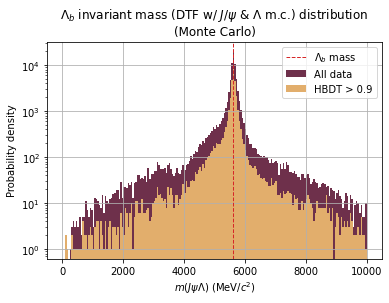

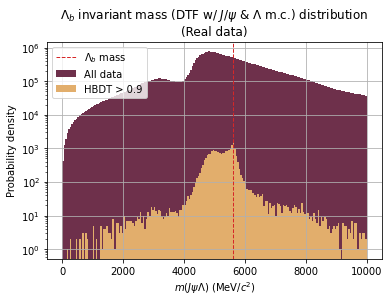

In [94]:
massRange = (0, 10000)
binNumber = 200
plotFileTemplate = 'lambdab_mass_distribution_selection'

plotFileName = 'MC_' + plotFileTemplate

plt.hist(df_mc[invariantMassVariable], color=plum,
         bins=binNumber, range=massRange, label='All data')
plt.hist(df_mc.loc[hbdt_cut_mc, invariantMassVariable], color=apricot,
         bins=binNumber, range=massRange, label=threshold_label)
plt.grid()
plt.yscale('log')
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Probability density')
plt.title(invariantMassVariableTitle + " distribution" + '\n(Monte Carlo)')
plt.axvline(lambdabPDGMass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend()
if save_plots:
    plt.savefig(plot_directory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()

plotFileName = 'Data_' + plotFileTemplate

plt.hist(df_data[invariantMassVariable], color=plum,
         bins=binNumber, range=massRange, label='All data')
plt.hist(df_data.loc[hbdt_cut_data, invariantMassVariable], color=apricot,
         bins=binNumber, range=massRange, label=threshold_label)
plt.grid()
plt.yscale('log')
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Probability density')
plt.title(invariantMassVariableTitle + " distribution" + '\n(Real data)')
plt.axvline(lambdabPDGMass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend()
if save_plots:
    plt.savefig(plot_directory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()

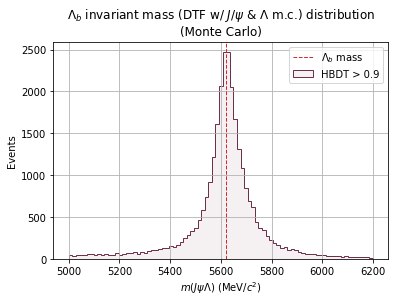

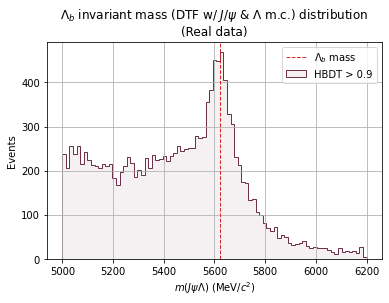

In [95]:
massRange = (5000, 6200)
binNumber = 85
plotFileTemplate = 'lambdab_mass_distribution_after_selection'

plotFileName = 'MC_' + plotFileTemplate

MC_events, MC_bins, MC_patches = plt.hist(
    df_mc.loc[hbdt_cut_mc, invariantMassVariable],
    histtype='stepfilled', color=HexToRGBA(lightplum,0.1), edgecolor=plum,
    bins=binNumber, range=massRange, label=threshold_label)

plt.grid()
#plt.yscale('log')
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.title(invariantMassVariableTitle + " distribution" + '\n(Monte Carlo)')
plt.axvline(lambdabPDGMass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend()
if save_plots:
    plt.savefig(plot_directory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()

plotFileName = 'Data_' + plotFileTemplate

data_events, data_bins, data_patches = plt.hist(
    df_data.loc[hbdt_cut_data, invariantMassVariable],
    histtype='stepfilled', color=HexToRGBA(lightplum,0.1), edgecolor=plum,
    bins=binNumber, range=massRange, label=threshold_label)

plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.title(invariantMassVariableTitle + " distribution" + '\n(Real data)')
plt.axvline(lambdabPDGMass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend()
if save_plots:
    plt.savefig(plot_directory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()